In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import joblib
df = pd.read_parquet('../data/processed.parquet')

In [115]:
feature_cols = ['circuit','fp1_time', 'fp2_time', 'fp3_time', 'quali_time', 'fp2_minus_fp1', 'fp3_minus_fp2'] 
X = df[feature_cols]
y = df['podium_finish']

X = pd.get_dummies(X, columns=['circuit'])

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=18)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [117]:
y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test) 


thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

print("=== THRESHOLD ANALYSIS ===")
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)
    print(f"\n--- Threshold: {threshold} ---")
    print(classification_report(y_test, y_pred))

    positive_predictions = sum(y_pred)
    print(f"Number of podium predictions: {positive_predictions}")

print("\n=== DEFAULT THRESHOLD (0.5) ===")
y_pred_default = (y_pred_proba[:, 1] >= 0.5).astype(int) 
print(classification_report(y_test, y_pred_default))

positive_predictions = sum(y_pred)
print(f"Number of podium predictions: {positive_predictions}")

=== THRESHOLD ANALYSIS ===

--- Threshold: 0.1 ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       372
           1       0.37      0.48      0.42        62

    accuracy                           0.81       434
   macro avg       0.64      0.67      0.65       434
weighted avg       0.83      0.81      0.82       434

Number of podium predictions: 81

--- Threshold: 0.2 ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       372
           1       0.37      0.48      0.42        62

    accuracy                           0.81       434
   macro avg       0.64      0.67      0.65       434
weighted avg       0.83      0.81      0.82       434

Number of podium predictions: 81

--- Threshold: 0.3 ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       372
           1       0.37      0.48      0.42        62

    accuracy     

In [118]:
print("=== PROBABILITY ANALYSIS ===")

podium_probs = y_pred_proba[:, 1][y_test == 1]
non_podium_probs = y_pred_proba[:, 1][y_test == 0]

print(f"Average probability for actual podium finishers: {podium_probs.mean():.3f}")
print(f"Average probability for non-podium finishers: {non_podium_probs.mean():.3f}")
print(f"Max probability for podium finisher: {podium_probs.max():.3f}")
print(f"Min probability for podium finisher: {podium_probs.min():.3f}")


high_prob_indices = np.where(y_pred_proba[:, 1] > 0.3)[0]
print(f"\nDrivers with >30% podium probability: {len(high_prob_indices)}")

=== PROBABILITY ANALYSIS ===
Average probability for actual podium finishers: 0.454
Average probability for non-podium finishers: 0.197
Max probability for podium finisher: 0.986
Min probability for podium finisher: 0.008

Drivers with >30% podium probability: 118


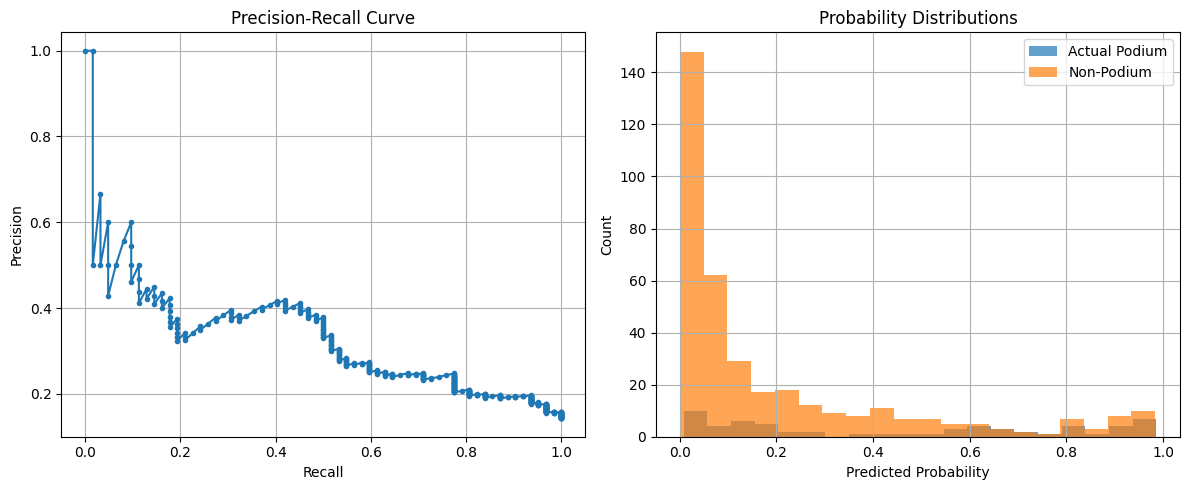

In [119]:

precision, recall, thresholds_curve = precision_recall_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(podium_probs, alpha=0.7, label='Actual Podium', bins=20)
plt.hist(non_podium_probs, alpha=0.7, label='Non-Podium', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Probability Distributions')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [120]:

def predict_podium_probability(circuit, fp1_time, fp2_time, fp3_time, quali_time):
    """
    Predict podium probability for a driver with given lap times
    """

    input_data = pd.DataFrame({
        'circuit': [circuit],
        'fp1_time': [fp1_time],
        'fp2_time': [fp2_time],
        'fp3_time': [fp3_time], 
        'quali_time': [quali_time],
        'fp2_minus_fp1': [fp2_time - fp1_time],
        'fp3_minus_fp2': [fp3_time - fp2_time]
    })
    

    input_processed = pd.get_dummies(input_data, columns=['circuit'])
    

    for col in X.columns:
        if col not in input_processed.columns:
            input_processed[col] = 0
    

    input_processed = input_processed[X.columns]
    

    prob = model.predict_proba(input_processed)
    
    return prob

print("Testing model predictions:")

print("Lando Norris prediction (Winner): ")
print(predict_podium_probability('Budapest', 76.052, 75.624, 74.916, 75.413)[0][1])

print("Oscar Piastri prediction (Goat): ")
print(predict_podium_probability('Budapest', 76.052 + 0.019, 75.624 + 0.291, 74.916, 75.398)[0][1])

print("Franco Colapinto prediction (Dog shit): ")
print(predict_podium_probability('Budapest', 77.464, 77.159, 76.279, 76.159)[0][1])

Testing model predictions:
Lando Norris prediction (Winner): 
0.56649107
Oscar Piastri prediction (Goat): 
0.34779143
Franco Colapinto prediction (Dog shit): 
0.19169547


In [121]:
joblib.dump(model, '../back-end-bridge/podium_model.pkl')
print("Model loaded to back end bridge")

Model loaded to back end bridge
